# The Evidence Approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap
from numpy.random import randn, seed
from numpy.linalg import inv, norm, det

In [2]:
%config InlineBackend.figure_format = "retina"

### Creating the Sinusoidal Synthetic Data

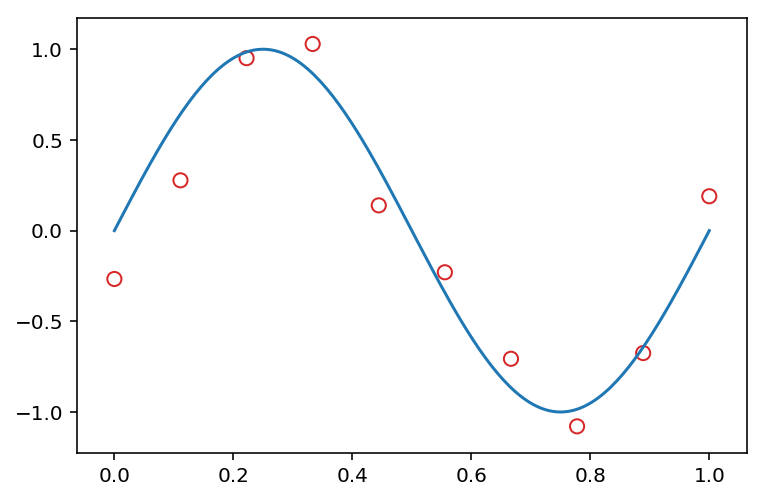

In [3]:
seed(1643)

nsteps = 200
x = np.linspace(0, 1, 200)
t_true = np.sin(2 * np.pi * x)

precision = 1 / 0.15
N = 10
x_train = np.linspace(0, 1, N)
t_train = np.sin(2 * np.pi * x_train) + randn(N) / precision

plt.plot(x, t_true)
plt.scatter(x_train, t_train, edgecolors="tab:red", c="None", s=50);

## The Setting
Under the context for a Gaussian linear regression with basis functions, given model $M_i$, seen training data $\bf t$ and a target vector $\bf x$,

$$
    p(t | {\bf t}, {\bf x}, M_i) = \int\int\int p(t, \alpha, \beta, {\bf w} | {\bf t}, {\bf x}, M_i) \ d{\bf w} \ d\alpha  \ d\beta
$$

With priors
$$
    p({\bf w} | {\bf t}, \alpha, \beta) = \mathcal{N}({\bf w} | m_N, S_N)
$$
$$
    p(t | {\bf w}, \beta) = \mathcal{N}(t | \Phi {\bf w}, \beta^{-1})
$$

For a given model $M_i$, the log-evidence function is given by
$$
    \log p({\bf t} | \alpha, \beta) = -\frac{N}{2} \log 2\pi + \frac{N}{2}\log\beta + \frac{M}{2}\log\alpha - \frac{1}{2}\log |S_N^{-1}| - E(m_N)
$$

Where
* $S_N^{-1} = \alpha {\bf I} + \beta \Phi^T\Phi$
* $m_N = \beta S_N \Phi^T {\bf t}$
* $E(m_N) = \frac{\beta}{2}{||{\bf t} - \Phi m_N||}^2 + \frac{\alpha}{2}m_N^Tm_N$

## Evaluating the Evidence Function

In [4]:
def gaussian_kernel(x, mu, s): return np.exp(-(x - mu)**2 / (2 * s ** 2))

def gaussian_design_matrix(x, mus, s, bias=True):
    """
    Create an N x (M + 1) desig matrix (if bias == True)
    with Gaussian basis functions
    
    Parameters
    ----------
    mus: numpy.ndarray(M, 1)
        Centres of the gaussian basis functions
    x: numpy.ndarra(N, 1)
        A 1-dimensional input vector
    s: float
        The scale term
    bias: bool
        Whether to include a bias term
    
    Returns
    -------
    Phi: numpy.ndarray(N, (M + bias))
    """
    Phi = gaussian_kernel(x[:, np.newaxis], mus[np.newaxis, :], s)
    if bias:
        r, _ = Phi.shape
        onevect = np.ones(r)
        Phi = np.column_stack((onevect, Phi))
    return Phi

def polynomial_design_matrix(x, powers, bias=True):
    """
    Create an N x (M + 1) desig matrix (if bias == True)
    with Gaussian basis functions
    
    Parameters
    ----------
    mus: numpy.ndarray(M, 1)
        Centres of the gaussian basis functions
    x: numpy.ndarra(N, 1)
        A 1-dimensional input vector
    s: float
        The scale term
    bias: bool
        Whether to include a bias term
    
    Returns
    -------
    Phi: numpy.ndarray(N, (M + bias))
    """
    Phi = np.column_stack((x ** p for p in powers))
    if bias:
        r, _ = Phi.shape
        onevect = np.ones(r)
        Phi = np.column_stack((onevect, Phi))
    return Phi


def posterior(Phi, t, alpha, beta):
    """
    Compute the posterior mean and covariance matrix
    for a set of weights with prior an isotropic gaussian.
    
    Parameters
    ----------
    Phi: numpy.ndarray (N, M)
        An N x M design matrix
    t: numpy.ndarray (N,)
        The training dataset
    alpha: float
        The prior 
    beta: float 
    
    Returns
    -------
    mN: numpy.ndarray(M, 1)
    SN: numpy.ndarray(M, M)
    """
    SN_inv = alpha + beta * Phi.T @ Phi
    mN = beta * inv(SN_inv) @ Phi.T @ t[:, np.newaxis]
    return mN, SN_inv


def log_evidence(M, alpha, beta, s=0.5):
    """
    Compute the log-evidence for a design matrix
    with gaussian basis functions
    """
    mus = np.linspace(0, 1, M)
    Phi = gaussian_design_matrix(x_train, mus, s, bias=True)
    mN, SN_inv = posterior(Phi, t_train, alpha, beta)
    
    E_mN = beta / 2 * norm(t_train[:, np.newaxis] - Phi @ mN) ** 2 + alpha / 2 * mN.T @ mN
    log_ev = N / 2 * np.log(beta) + M / 2 * np.log(alpha) - \
             1 / 2 * np.log(det(SN_inv)) - E_mN - N / 2  * np.log(2 * np.pi)
    return np.asscalar(log_ev)

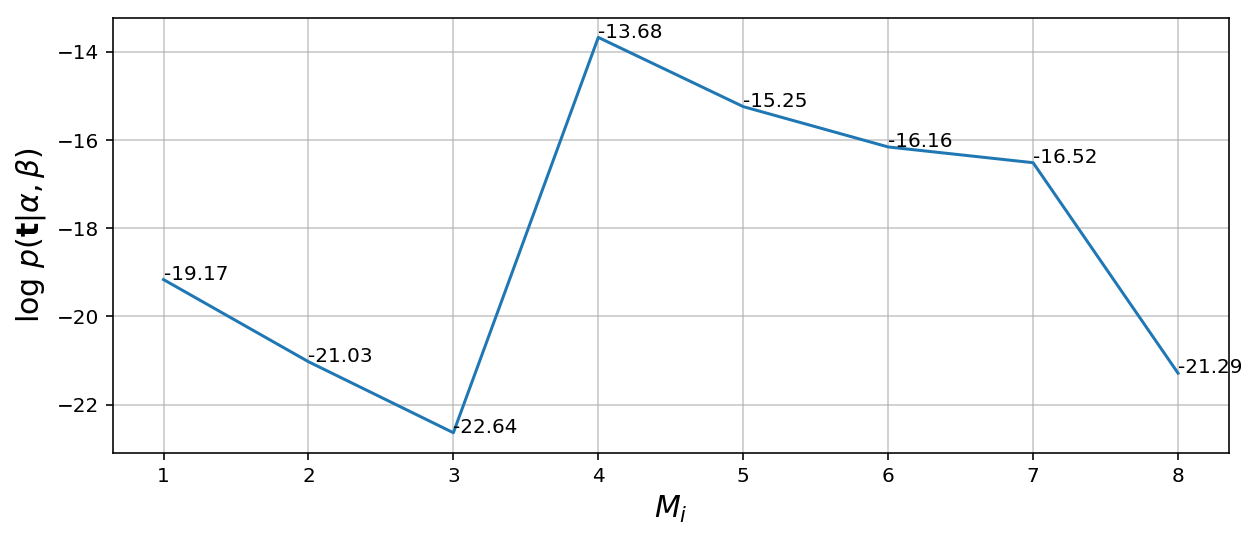

In [5]:
alpha, beta = 0.01, precision + 1
s = 0.2
models = [1, 2, 3, 4, 5, 6, 7, 8]

evidences = [log_evidence(M, alpha, beta, s=s) for M in models]

plt.figure(figsize=(10, 4))
plt.plot(models, evidences)
for m, ev in zip(models, evidences):
    plt.text(m, ev, f"{ev:0.2f}", horizontalalignment="left")
plt.grid(alpha=0.7)
plt.xlabel("$M_i$", size=15)
plt.ylabel(r"$\log\ p({\bf t} | \alpha, \beta)$", size=15);

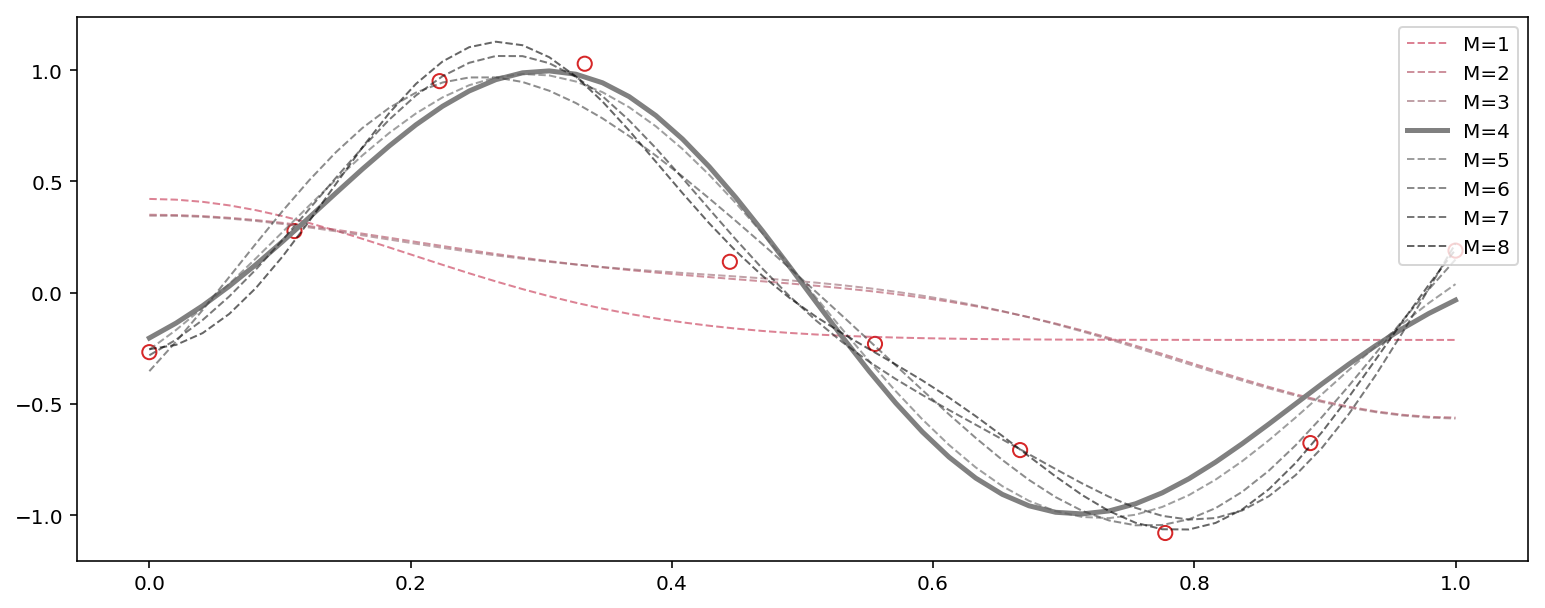

In [6]:
plt.figure(figsize=(13, 5))
plt.scatter(x_train, t_train, c="None", s=50, edgecolor="tab:red")
cmap = LinearColormap(["crimson", "gray", "black"])
for i, M in enumerate(models):
    mus = np.linspace(0, 1, M)
    Phi = gaussian_design_matrix(x_train, mus, s)
    mN, SN_inv = posterior(Phi, t_train, alpha, beta)
    x_in = np.linspace(0, 1, 50)
    phi_x = gaussian_design_matrix(x_in, mus, s, bias=True)
    linestyle = "--" if M != 4 else "-"
    alpha = 0.6 if M != 4 else 1
    linewidth = 1 if M != 4 else 2.5
    plt.plot(x_in, (mN.T @ phi_x.T).ravel(), label=f"M={M}",
             linestyle=linestyle, alpha=alpha,
             linewidth=linewidth,
             c=cmap((i + 1) / len(models)))
plt.legend();

## Maximizing the Evidence Function
With the log-evidence function, for a given model $M_i$, it can be show that $\alpha$ and $\beta$ that maximize the evidence function are given by

$$
    \alpha = \frac{\gamma}{{\bf m}_N^T {\bf m}_N} \qquad \frac{1}{\beta} = \frac{1}{N - \gamma}\sum_{n=1}^N \left(t_n - {\bf m}_N^T \phi({\bf x}_n) \right)^2
$$

With
$$
    \gamma = \sum_i \frac{\lambda_i}{\alpha + \lambda_i}
$$